Federal University of Rio Grande do Sul (UFRGS) <br/>
Postgraduate Civil Engineering Program (PPGEC) <br/>
### Laboratório de Aerodinâmica das Construções (LAC)
_Prof. Marcelo M. Rocha, Dr.techn._  <br/>
_Porto Alegre, RS, Brazil_


---

# Notebook: HFPI Module Description
---

In [1]:
# Configurations and imports... don't bother reading this part!

%config InlineBackend.figure_formats = {'png', 'retina'} #{'svg',}  
%matplotlib inline

import numpy   as np             # Module for numerical analysis
import matplotlib.pyplot as plt  # Module for plotting

from mpl_toolkits.mplot3d import Axes3D   # For 3D plots

import HFPI   # High Frequency Pressure Integration
import URP    # Univariate Random Process


ModuleNotFoundError: No module named 'HFPI'

## 1. Intro

---

This IPython Notebook presents the use of HFPI module, exemplifying how the large amount of data from wind tunnel tests and from the building structural design are brought together to yield the building dynamic response to wind action.

The Wind Tunnel provides a directory with a set of Scanivalve files, one file per wind direction. The so-called _Master Table_ connects the Scanivalve channels in each file to the corresponding pressure taps in the model. The _Master Table_ also provides further information for pressure integration over building surface. 

The building designer provides information from the numerical model used for structural analysis. Nodal coordinates, nodal masses, natural frequencies of vibration and the respective modal shapes are used to calculate the building response through modal superposition. 

The link between wind tunnel and structural model are the modal forces, which are obtained by projecting the aerodynamic forces on modal space. The modal responses are finally combined to yield the total response, from which static equivalent forces may be specified and provided to building designer for accomplishing the structural design. 

The example carried on in this notebook is the CAARC standard tall building. 


## 2. Preprocessing the Scanivalve files
---

### 2.1 The _Master Table_

Each Wind Tunnel test results in a set of Scanivalve (ASCII) files, each file associated with a wind direction. The tests make use of a rigid model instrumented with hundreds of pressure taps. The tunnel is configured according to a specified setup for both close field neighborhood and far field terrain roughness. The setup defines the wind turbulence reaching the model. A single building model may be tested for more than on setup.

The Scanivalve files must be preprocessed to become associated with model taps. The files give the instantaneous pressure at each channel in the data acquisition system. To link the channels to pressure taps a _Master Table_ must provide the complete mapping. The _Master Table_ has one line for each tap, plus two lines for the reference pressures $A_1$ and $A_2$ (related to the instantaneous velocity in the tunnel). The table columns bring all required tap information, as described bellow.

<img src="resources/Master Table.png" alt="Master Table"/>

The format above provides the possibility of assign not only one, but two channels to each pressure tap, what can be used to build a _virtual tap_, defined as the mean value between two adjacent taps. When this feature is not required (as it is usually the case) the information in columns (2) and (3) must be repeated.

The reference pressures $A_1$ and $A_2$ are identified by setting $-1$ and $-2$ in column (6), respectivelly. For these two channels, further columns are not used and may be filled with zeros.

The measurement phase in column (7) is required whenever tap pressures are not to be simultaneously recorded. In this case, data assembling is performed by combining two or more Scanivalve file sets. This is seldomly required for buildings, but may be necessary when testing, for instance, a large stadium roofing. Usually column (7) will be filled with 1's.


### 2.2 The _Batch Table_

Each Scanivalve acquisition is carried out with a given setup and results in a file, which must be associated to experimental parameters. This association is informed in the _Batch Table_, given as an ASCII file with one line per acquisition. The columns in this table contains the information as described bellow.

<img src="resources/Batch Table.png" alt="Batch Table"/>

A wind tunnel test (set of Scanivalve acquisitions) may have more than one _Master Table_ if, for instance, tap connections had to be changed between acquisitions. The terrain roughness category may be a decimal number, what implies that wind profile will be interpolated accordingly. The category may change with the wind direction, and is used to define the (prototype scale) dynamic pressure at building top.

A further parameter associated with each acquisition is the $\Delta Pa = A_1 - A_2$ pressure, used along with the blockage factor in the calculation of the (nondimensional) pressure coefficients. This parameter will be internally appended to each line in the Batch Table, and will be available after post-processing.


### 2.3 The function "**HFPI.ScanivaleProcess**"

Both the _Master Table_ and the _Batch Table_ may be provided for processing each Scanivalve data set, what is handled by the module function "**HFPI.scanivalve_process**". 
To demonstrate the use of this function, we firstly define the paths for the requided files and data:


In [1]:
dirname = 'Data/E01/'  # path to Scanivalve files
prefix  = 'E01_IS023'  # subfolder name (also to build names for working files)


and then call the processing function:

In [52]:
batch = HFPI.scanivalve_process(dirname, prefix, ready=True)


If "**ready**" is set to "**False**", or simply ommited to cause default condition, the command above will take a very long time to run, looping over as many files as wind directions, each one approximatelly 50Mb. This is required to happen only once, and all data is processed and stored for later use. Once processed data files are available, by setting "**ready**" to "**True**" will only cause the "**batch**" dictionary to be reloaded.

The function processes the dataset according to the instructions in the _Batch Table_, which is provided as an ASCII file "E01_IS023_Batch.txt". 

The function returns the dictionary "batch", where the keys are the wind directions available. Let us take a look at it's content by iterating over the dictionary values:


In [53]:
for b in batch.values():
    print('File:     {0}'.format(b['file']))
    print('Category: {0}'.format(b['cat']))
    print('V model:  {0:3.2f}m/s'.format(b['Vm']))
    print('dPa:      {0:3.2f}Pa'.format(b['dPa']))
    print('T:        {0:3.2f}s'.format(b['T']),'\n')


File:     Data/E01/E01_IS023/E01_IS023_000.gz
Category: 3.5
V model:  26.00m/s
dPa:      41.25Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_195.gz
Category: 3.5
V model:  26.00m/s
dPa:      40.74Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_135.gz
Category: 3.5
V model:  26.00m/s
dPa:      40.43Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_330.gz
Category: 3.5
V model:  26.00m/s
dPa:      40.58Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_075.gz
Category: 3.5
V model:  26.00m/s
dPa:      40.32Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_270.gz
Category: 3.5
V model:  26.00m/s
dPa:      40.07Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_015.gz
Category: 3.5
V model:  26.00m/s
dPa:      41.10Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_210.gz
Category: 3.5
V model:  26.00m/s
dPa:      40.54Pa
T:        16.78s 

File:     Data/E01/E01_IS023/E01_IS023_150.gz
Category: 3.5
V model:  26

Observe that for a dictionary, the iteraction is unordered.

## 3. Making direct used of processed pressure data

---

To illustrate the use of the processed data files, let us specify a wind direction and a tap ID.
For instance, let us take wind direction equal to 60 degrees, and tap ID = 20:

In [54]:
wnd = 60
tap = 20


The pressure data can be loaded from the zipped pickle file with the following command: 

In [55]:
Z, X, A, C = HFPI.get_taps(batch, wnd)

where the returned variables contains the following data:

* "Z": the pressure zone to which the tap belongs, to be used for partial integration
* "X": the tap coordinates (in the wind tunnel reference system)
* "A": the tap integration area, projected the three directions
* "C": the pressure coefficient as a time series

To access the corresponding information for a specified tap, the tap ID is used as a key for the above dictionaries. For instance, to plot the pressure coeficiente as a time history:


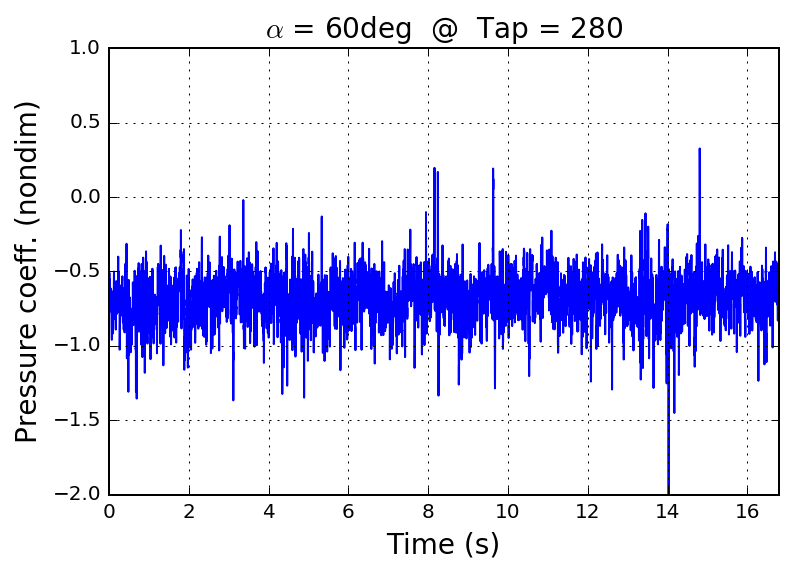

In [66]:
m  = len(C.keys())      # number of taps
n  = len(C[tap])        # number of time steps

T  = batch[wnd]['T']    
t  = np.linspace(0,T,n)

plt.plot(t,C[tap],'b');

plt.axis([0, T, -2, +1])
plt.title(r'$\alpha$ = {0}deg  @  Tap = {1}'.format(wnd, tap), size=14)    
plt.xlabel('Time (s)', size=14)
plt.ylabel('Pressure coeff. (nondim)', size=14)
plt.grid(True);


If the mean value and standard deviation in all taps are required, an iteration over the key is carried on:

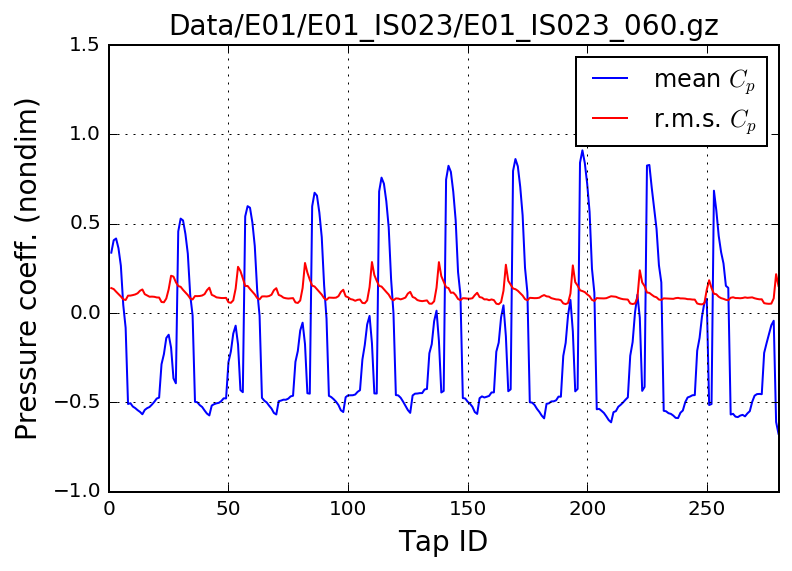

In [63]:
mp = np.empty((m,))                # initialize mean and standard deviation...
sp = np.empty((m,))                # ... as Numpy Arrays.
tp = np.empty((m,))

for ii, tap in enumerate(C):       # use enumeration to address Numpy array...
    tp[ii] = tap                   # ... but data is collected unsorted.
    mp[ii] = np.mean(C[tap],0)
    sp[ii] = np.std( C[tap],0)

kk = np.argsort(tp)                # sort all collected data

plt.plot(tp[kk], mp[kk], 'b')      # plot sorted (otherwise it'd be a mess).
plt.plot(tp[kk], sp[kk], 'r')

plt.axis([0, m, -1, +1.5])
plt.title(batch[wnd]['file'], size=14)    
plt.legend((r'mean $C_p$', r'r.m.s. $C_p$'))
plt.xlabel('Tap ID', size=14)
plt.ylabel('Pressure coeff. (nondim)', size=14)
plt.grid(True);


The Python code above is also an example on how to collect any ordered property from data.

## 4. Linking pressure data to structural model

---

Reading structural data:

In [58]:
mass  =  dirname + 'E01_Masses'
freq  =  dirname + 'E01_Frequencies'
mode  =  dirname + 'E01_Modes'
strc  =  dirname + 'E01_Structure'

Si, ZS, MS, fk, QS = HFPI.read_singlecolumn(mass, freq, mode, strc)


Visualizing modal shapes

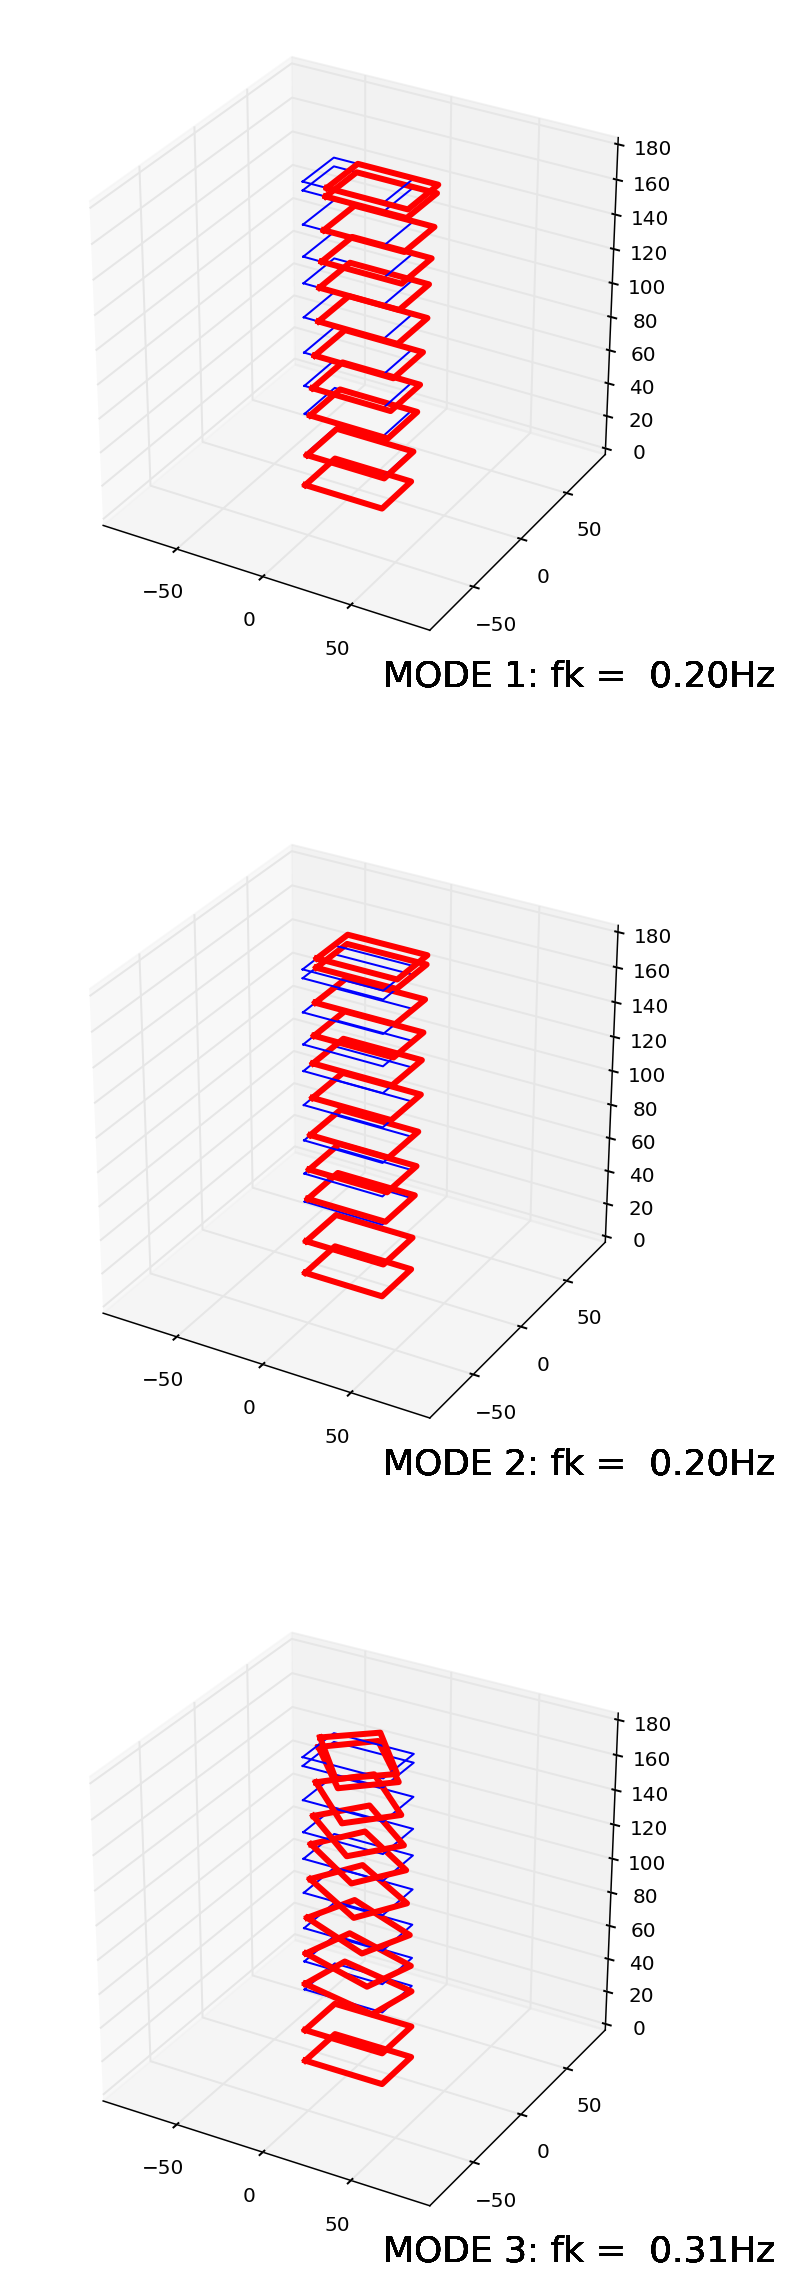

In [60]:
B   =  45.      # building accross wind dimension
D   =  30.      # building along wind dimension
H   =  180.     # building top height (from surface)
sc  =  50000.   # scaling for modes visualization

fig = plt.figure(figsize=(6,20))
HFPI.view_singlecolumn(fig, B, D, H, ZS, fk, QS, sc)
